In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

assert LooseVersion(tf.__version__) >= LooseVersion('1.0')
print("Tensorflow Version : {}".format(tf.__version__))

if not tf.test.gpu_device_name():
    warnings.warn("No GPU Found : Pelase Ensure you have installed TensorFlow correctly")
else:
    print("Default GPU Device:{}".format(tf.test.gpu_device_name()))

Tensorflow Version : 2.11.0


C:\Users\mdaff\AppData\Local\Temp\ipykernel_500380\3017287717.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert LooseVersion(tf.__version__) >= LooseVersion('1.0')
C:\Users\mdaff\AppData\Local\Temp\ipykernel_500380\3017287717.py:9: UserWarning: No GPU Found : Pelase Ensure you have installed TensorFlow correctly
  warnings.warn("No GPU Found : Pelase Ensure you have installed TensorFlow correctly")


In [3]:
#Arsitektur CNN
from tensorflow.keras import layers, models, callbacks

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.metrics import sparse_categorical_crossentropy

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

import os
import pandas as pd

In [4]:
class_names = ['ba', 'ca', 'da', 'ga', 'ha', 'ja', 'ka', 'la', 'ma',
           'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'wa', 'ya']

In [5]:
import sys
from PIL import Image
sys.modules['Image'] = Image

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(128, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(256, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(30, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [7]:
PATH = 'dataset'
VAL_DATA = 'test_mixed'
TOTAL_TRAIN_DATA = 3780
TRAIN_DIR = os.path.join(PATH, 'train')
VALIDATION_DIR = os.path.join(PATH,VAL_DATA)

BATCH_SIZE = 56
IMG_SIZE = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb')


validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb')

# i=0
# for batch in train_datagen.flow_from_directory(TRAIN_DIR,
#                                                     batch_size = BATCH_SIZE,
#                                                     class_mode='sparse',
#                                                     target_size=IMG_SIZE,
#                                                     color_mode='rgb',
#                                                     save_to_dir='augmented',
#                                                     save_prefix='aug',
#                                                     save_format='jpg'):
#     i += 1
#     if i > 0:
#         break


Found 3780 images belonging to 18 classes.
Found 1620 images belonging to 18 classes.


In [8]:
model_save_callback = callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}_{accuracy:.3f}.h5',save_best_only=False,save_weights_only=False,monitor='val_accuracy')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  # Corrected spelling of 'metrics'

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=105,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[model_save_callback]
                    )

Epoch 1/2
 8/67 [==>...........................] - ETA: 40s - loss: 3.1924 - accuracy: 0.0714

KeyboardInterrupt: 

In [9]:
pd.DataFrame(history.history).to_csv("history.csv")

plt.plot(history.history['accuracy'], label='traning accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1])
plt.legend(loc='right')
plt.savefig('train_val_acc_augmentation.png')
plt.show()

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0., 3.5])
plt.legend(loc='right')
plt.savefig('train_val_loss_augmentation.png')
plt.show()

NameError: name 'history' is not defined

In [10]:
loaded_model = models.load_model('models/bestModel.h5')

In [11]:
def load_image(img_path):
    img = load_img(img_path, target_size=(150,150,3))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor,axis=0)
    img_tensor /= 255.0

    return img_tensor

In [12]:
PATH = 'dataset'
VAL_DATA = 'test_mixed'
VALIDATION_DIR = os.path.join(PATH,VAL_DATA)

BATCH_SIZE = 56
IMG_SIZE = (150,150)

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb')


Found 1620 images belonging to 18 classes.


1/1 [==============================] - 0s 27ms/step
17


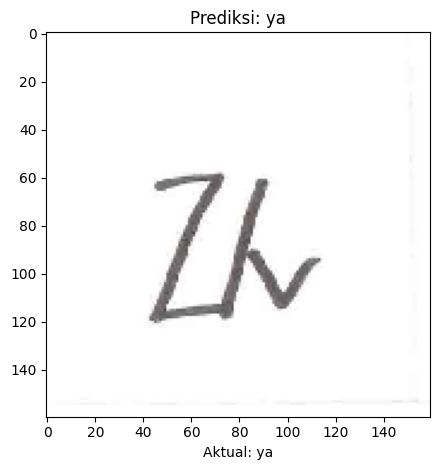

In [14]:
huruf = input("Nama Huruf : ")
img_path = 'dataset/' + VAL_DATA + '/' + huruf + '/'+ huruf + '.15.jpg'
new_image = load_image(img_path)

pred = loaded_model.predict(new_image)
pred *= 100
print(np.argmax(pred))

img = load_img(img_path, target_size=(160,160))
plt.imshow(img)
plt.title("Prediksi: {}".format(class_names[np.argmax(pred)]))
plt.xlabel("Aktual: " + img_path.split("/")[2])
plt.tight_layout()
plt.show()


In [15]:
from ipywidgets import *
from IPython.display import clear_output, display
from tkinter import Tk, filedialog

def select_files(file):
    clear_output()
    root = Tk()
    root.withdraw()
    root.call('wm','attributes','.','-topmost', True)
    file.files = filedialog.askopenfilename(multiple=True)
    print(file.files)

In [21]:
fileselect = Button(description="File Select")
fileselect.on_click(select_files)

display(fileselect)

('C:/Users/mdaff/Desktop/test/JAHAHHAHAHA.jpg',)


1/1 [==============================] - 0s 51ms/step
5


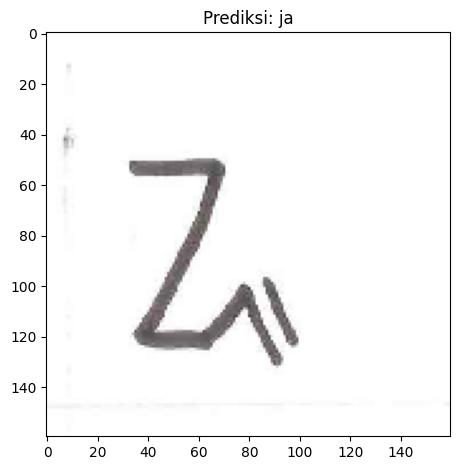

In [22]:
files = fileselect.files
img_path = files[0]
new_image = load_image(img_path)

pred = loaded_model.predict(new_image)
pred *= 100
print(np.argmax(pred))

img = load_img(img_path, target_size=(160,160))
plt.imshow(img)
plt.title("Prediksi: {}".format(class_names[np.argmax(pred)]))
plt.tight_layout()
plt.show()